![TeamName](https://media.giphy.com/media/3og0ITQOC5wlyk8ffy/giphy.gif "pied pipper")

In [14]:
import numpy as np
import itertools

import cirq
import numpy as np
import matplotlib 

In [35]:
class UF(cirq.Gate):
    def set_num_qubits(self, n):
        self.n = n
        
    def num_qubits(self):
        return self.n
    
    def set_oracle(self, f):
        self.f = f
        
    def _unitary_(self):
        return self.create_Uf(self.f, self.n)
    
    def create_Uf(self, f, n):
        """
        Function to create Ux matrix

        @param f: Input function that we want to encode
        @param n: Number of qubits. This should be 1+(len(input to f))

        @return: Numpy matrix Uf
        """
        dim = 2**n
        # creating a 2^n x 2^n zeros matrix. 
        Uf = np.zeros((dim, dim), dtype=int)
        # This creates a list of the different permutations of n bits. 
        lst_bitseq = list(map(list, itertools.product([0, 1], repeat=n)))
        for col, bitseq in enumerate(lst_bitseq):
            # applying the operation on the last helper bit. 
            last_bit = bitseq[-1] ^ f(bitseq[:-1])
            final_bitseq = [bit for bit in bitseq]
            final_bitseq[-1] = last_bit
            # using the To-Form method discussed in class to help create the Uf matrix. 
            Uf[lst_bitseq.index(final_bitseq), col] = 1
        return Uf

In [116]:
def create_dj_circuit(f, qubits):
    """
    This function will create the program.
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. This should be 1+(len(input to f))
    
    @return: Pyquil Program
    """
    uf = UF()
    uf.set_num_qubits(len(qubits))
    uf.set_oracle(f)
    
    for i in qubits[:-1]:
        yield cirq.I(i)
    yield cirq.X(qubits[-1])
    yield cirq.H.on_each(*qubits)
    yield uf(*qubits)
    yield cirq.H.on_each(*qubits[:-1])
    yield cirq.measure(*qubits[:-1], key="result")

In [117]:
def bitstring(bits):
    return ''.join(str(int(b)) for b in bits)

def run_circuit(f, n):
    """
    creates and runs a circuit
    
    @param f: Input function that we want to encode
    @param n: Number of qubits. This should be 1+(len(input to f))
    
    @return: result
    """
    simulator = cirq.Simulator()
    qubits = cirq.LineQubit.range(n)
    circuit = cirq.Circuit.from_ops(create_dj_circuit(f, qubits))
    result = simulator.run(circuit, repetitions=1000) 
    return result


In [131]:
def run_dj(f, n):
    """
    Runs Deutsch–Jozsa on f and n
    
    @param f: Input function that we want to encode
    @param n: n is length of input to the function
    
    Prints either constant or balanced
    """
    
    result = run_circuit(f, n+1)
    frequencies = result.histogram(key='result', fold_func=bitstring)
    most_common_bitstring = frequencies.most_common(1)[0][0]
    if(most_common_bitstring == '0'*n):
        print('Function is constant')
    else:
        print("Function is balanced")


In [139]:
def run_bv(f, n):
    """
    Runs Bernstein-Vazirani on f and n
    
    @param f: Input function that we want to encode
    @param n: n is length of input to the function
    
    Prints the value of a and b of f
    """
    result = run_circuit(f, n+1)
    b = f([0]*(n))
    frequencies = result.histogram(key='result', fold_func=bitstring)
    most_common_bitstring = frequencies.most_common(1)[0][0]
    a = most_common_bitstring
    print("Function is defined with a={0}, b={1}".format(a, b))

## Design

**Present the design of how you implemented the black-box function U_f.  Assess how visually neat and easy to read it is.**

We know that Uf|x>|b> = |x>|b+f(x)> where Uf is the unitary matrix representing the blackbox function f. For n qubits, we first find all the different permutations of the bits in their two states (0,1) and then apply the operation f(x) xor'd with the last qubit (the helper bit) to get a new state for each of those permutations. Using this knowledge of knowing the initial qubit states and the resulting qubit states after applying the operation, we can create the Uf matrix using the "From - To" idea that the professor covered in class. I would it personally give it a 10/10 on how visually neat and easy to read it is. 


**Present the design for how you prevent the user of U_f from accessing the implementation of U_f.  Assess how well you succeeded.**

We can use Cython, Nuitka, Shed Skin or something similar to compile python to C code, then distribute the file containing the function as a python binary library (pyd) instead. We didn't apply this method for this homework, but I presume this would be enough to abstract the functionality of Uf creation. However for a determined user, you can't really hide the implementation using Python. 

**Present the design of how you parameterized the solution in n.** 

When creating the Uf matrix, we took n as an arguement to the create_Uf() function and accordingly created a unitary matrix $U_f \in \{1,0\}^{2^n \times 2^n}$ and the filled it using the method described in the first answer. For the quantum circuit, we created a string to define the n qubits that Uf would be applied to and passed it as an arguement to our Program object. 

**Discuss the number of lines and percentage of code that your two programs share.  Assess how well you succeeded in reusing code from one program to the next.**

We pretty much re-used the entire code for both these programs as the quantum circuit for both of them are exactly the same. All we had to change was the black-box functions for testing our code and some classical post-processing to print the answer

# Look at the 4 cases below to see that there is a difference in execution time for different input of Uf

Especially notice that first case is faster than all the other cases

### Constant function that always returns 0 on input of length 4 

In [133]:
%%time
run_dj((lambda x: 0), 4)

Function is constant
CPU times: user 10.2 ms, sys: 3.11 ms, total: 13.3 ms
Wall time: 10.4 ms


### Constant function that always returns 1 on input of length 4 

In [134]:
%%time
run_dj((lambda x: 1), 4)

Function is constant
CPU times: user 10.3 ms, sys: 2.71 ms, total: 13 ms
Wall time: 10.5 ms


### Balanced function that returns not of the partiy of bits on input of length 4

In [135]:
%%time
run_dj((lambda x: sum(x)%2 ^ 1), 4)

Function is balanced
CPU times: user 9.98 ms, sys: 2.81 ms, total: 12.8 ms
Wall time: 10.6 ms


### Balanced function that returns the partiy of bits on input of length 4

In [136]:
%%time
run_dj((lambda x: sum(x)%2), 4)

Function is balanced
CPU times: user 9.23 ms, sys: 1.65 ms, total: 10.9 ms
Wall time: 9.29 ms


# Now we will look at how long it takes as input size increases 

I am only providing results for the case where we always return constant but it is easy to do this for the rest of the cases. Using this test case as it is the only example where I could successfully get result up to size of input 7, in other cases we are seeing a timeout after 4 or 5.

Function is constant
Function is constant
Function is constant
Function is constant
Function is constant
Function is constant
Function is constant


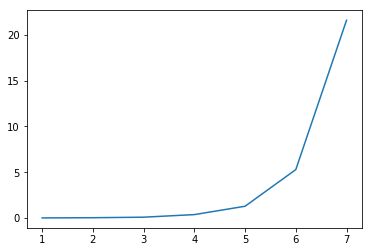

In [11]:
%matplotlib inline
import time
import matplotlib.pyplot as plt

time_it_took = []

for i in range(1,8):
    start = time.time()
    run_dj((lambda x: 0), i)
    end = time.time()
    time_it_took.append(end-start)
    
plt.plot(list(range(1,8)), time_it_took)
plt.show()

# Now running some test to show that Bernstein-Vazirani also works

In [140]:
%%time
run_bv((lambda x: (np.dot([1, 0], x)%2) ^ 1), 2)

Function is defined with a=10, b=1
CPU times: user 7.98 ms, sys: 1.28 ms, total: 9.26 ms
Wall time: 8.2 ms


In [141]:
%%time
run_bv((lambda x: (np.dot([1, 0, 1, ], x)%2) ^ 0), 3)

Function is defined with a=101, b=0
CPU times: user 9.33 ms, sys: 1.14 ms, total: 10.5 ms
Wall time: 9.39 ms


In [142]:
%%time
run_bv((lambda x: (np.dot([1, 0, 0, 1], x)%2) ^ 1), 4)

Function is defined with a=1001, b=1
CPU times: user 10.9 ms, sys: 2.05 ms, total: 12.9 ms
Wall time: 11.1 ms


# How to use our code?

Running this is straightforward. We have written two functions run_dj and run_bv. The arguments for both functions are the same. The first argument is the name of the function that we are using and the 2nd argument is length of the input to this function. Examples above